# General file to process DepMap database









In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr


# Function to load DepMap file into a pandas DataFrame

File path to the DepMap file




In [2]:
import pandas as pd

def load_depmap_file(file_path, separator=','):
    """
    Loads a CSV file into a Pandas DataFrame.
    The functions relay on pandas
    Parameters:
        file_path (str): The full path to the CSV file.
        separator (str): The delimiter used in the CSV file (default is ',').

    Returns:
        pd.DataFrame: The loaded DataFrame.
    """
    try:
        df = pd.read_csv(file_path, sep=separator)
        print(f"File loaded successfully: {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except pd.errors.ParserError as e:
        print(f"Error: Failed to parse the file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Create a more general function to extract information from DepMap 

This function takes the following inputs:

df_dm (pd.DataFrame): DepMap database.

df_inz (pd.DataFrame): Input database with columns:

gene1_input_col (str): Column name for Gene1 in df_inz.

gene2_input_col (str): Column name for Gene2 in df_inz.

reagent_id_col (str, optional): Column name for ReagentID in `df_inz. Default is 'ReagentID'.

It returns a tuple of two DataFrames:

Final expression DataFrame: Contains the extracted information from the DepMap database.

Missing genes DataFrame: Lists genes not found in the DepMap database.

In [3]:
def process_gene_expression_data(df_dm, df_inz, gene1_input_col, gene2_input_col, 
                                 gene1_output_col='', 
                                 gene2_output_col='', 
                                 gene_combination_col="Gene_combination"):
    """
    Process gene data from the DepMap database and extract the overlap to gene pairs of interest based on inputs from df_inz.
    The function relies on pandas DataFrame.

    Args:
        df_dm (pd.DataFrame): DepMap database.
        df_inz (pd.DataFrame): Input database with Gene1, Gene2, and optionally Gene_combination.
        gene1_input_col (str): Column name for Gene1 in df_inz.
        gene2_input_col (str): Column name for Gene2 in df_inz.
        gene1_output_col (str): Column name for Gene1 in the output. 
        gene2_output_col (str): Column name for Gene2 in the output. 
        gene_combination_col (str, optional): Column name for Gene_combination in df_inz. Default is 'Gene_combination'.
        
    Returns:
        tuple: A tuple of two DataFrames:
            - Final expression DataFrame with columns ['Cell_Line', gene1_output_col, 
              gene2_output_col, 'Gene_combination'].
            - Missing genes DataFrame with columns ['Gene_combination', 'Gene1', 'Gene2', 'Missing_Genes'].
    """
    # Clean the column headers in df_dm
    df_dm.columns = [col.split(" (")[0] if " (" in col else col for col in df_dm.columns]
    
    # Initialize an empty list to hold the data for Gene1 and Gene2 expression
    expression_data = []

    # Initialize a list to keep track of missing genes
    missing_genes_data = []

    # Iterate over each row in df_inz to extract Gene1 and Gene2 expressions
    for _, row in df_inz.iterrows():
        gene_combination = row[gene_combination_col]
        gene1 = row[gene1_input_col]
        gene2 = row[gene2_input_col]

        # Check if Gene1 and Gene2 are present in df_dm columns
        if gene1 in df_dm.columns and gene2 in df_dm.columns:
            # Extract expression data for all cell lines and store it in a temporary DataFrame
            temp_df = df_dm[['Unnamed: 0', gene1, gene2]].copy()
            
            # Set default column names if not provided
            if not gene1_output_col:
                gene1_output_col = f"{gene1}_damage_mutation"
            if not gene2_output_col:
                gene2_output_col = f"{gene2}_damage_mutation"
            
            # Rename columns and add Gene_combination
            temp_df.columns = ['cell_line', gene1_output_col, gene2_output_col]
            temp_df['Gene_combination'] = gene_combination
            
            # Append to the list
            expression_data.append(temp_df)
        else:
            # Track missing genes for this gene combination
            missing_genes = []
            if gene1 not in df_dm.columns:
                missing_genes.append(gene1)
            if gene2 not in df_dm.columns:
                missing_genes.append(gene2)
            
            # If there are missing genes, add to the missing genes data list
            if missing_genes:
                missing_genes_data.append({
                    'Gene_combination': gene_combination,
                    'Gene1': gene1,
                    'Gene2': gene2,
                    'Missing_Genes': ', '.join(missing_genes)
                })
                print(f"Genes not found for Gene_combination {gene_combination}: {', '.join(missing_genes)}")

    # Prepare final expression DataFrame
    if expression_data:
        final_expression_df = pd.concat(expression_data, ignore_index=True)
    else:
        final_expression_df = pd.DataFrame(columns=['Cell_Line', gene1_output_col, 
                                                    gene2_output_col, 'Gene_combination'])

    # Prepare missing genes DataFrame
    if missing_genes_data:
        missing_genes_df = pd.DataFrame(missing_genes_data)
    else:
        missing_genes_df = pd.DataFrame(columns=['Gene_combination', 'Gene1', 'Gene2', 'Missing_Genes'])
    
    return final_expression_df, missing_genes_df


# Function plot the distruption of the original data extracted from DepMap 

This function take the Final expression DataFrame from above and plot the original data distription

In [4]:

def plot_depmap_distribution(df, gene1_col, gene2_col, figsize=(14, 7), bins=20, colors=('blue', 'green')):
    """
    Plots the distribution of dependency scores for two genes.
    The function relay on matplotlib.pyplot and seaborn
    Parameters:
        df (pd.DataFrame): The input dataframe containing gene dependency data.
        gene1_col (str): The column name for Gene1 
        gene2_col (str): The column name for Gene2 
        figsize (tuple): Figure size for the plot (default: (14, 7)).
        bins (int): Number of bins for the histogram (default: 20).
        colors (tuple): Tuple of colors for the histograms (default: ('blue', 'green')).
    """
    # Check if the dataframe has data
    if not df.empty:
        plt.figure(figsize=figsize)
        
        # Create histogram for Gene1 dependency scores
        plt.subplot(1, 2, 1)
        sns.histplot(df[gene1_col], kde=False, color=colors[0], bins=bins)
        plt.title(f'Distribution of {gene1_col} values')
        plt.xlabel(f'{gene1_col} values')
        plt.ylabel('Frequency')
        
        # Create histogram for Gene2 dependency scores
        plt.subplot(1, 2, 2)
        sns.histplot(df[gene2_col], kde=False, color=colors[1], bins=bins)
        plt.title(f'Distribution of {gene2_col} values')
        plt.xlabel(f'{gene2_col} values')
        plt.ylabel('Frequency')
        
        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        print("No expression data available for visualization.")


# Function to Extract Specific Cell Lines Values from DepMap Database

Function to Extract Specific Cell Lines from DepMap Database
The input is a pandas DataFrame of the processed file, which is the first output of the function process_gene_expression_data. The columns contain cell line names, and you also provide a list of the cell lines you want to extract. The cell line names should correspond to the DepMap cell line identifiers.

The function will output the extracted values for the specified cell lines.

In [5]:
def filter_cell_lines(df, cell_line_column, cell_line_list):
    """
    Filters the dataframe based on a list of specific cell lines.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing data.
        cell_line_column (str): The column name where cell line information is stored.
        cell_line_list (list): The list of cell lines to filter.
    
    Returns:
        pd.DataFrame: A filtered dataframe containing only the rows with the specified cell lines.
    """
    if cell_line_column not in df.columns:
        raise ValueError(f"Column '{cell_line_column}' does not exist in the dataframe.")
    if not cell_line_list:
        raise ValueError("The list of cell lines to filter cannot be empty.")
    
    filtered_df = df[df[cell_line_column].isin(cell_line_list)]
    return filtered_df

# Function to Calculate the Correlation Between Gene Values in DepMap

This function calculates the Pearson correlation coefficient between the values of two genes across different cell lines. The inputs to the function include:

The column names for the first and second genes.

A DataFrame containing the processed gene expression data (output from the process_gene_expression_data function).


The column name identifying gene categories (e.g., gene_id), which is used to group the data by different gene categories.

The function uses the pearsonr method from the scipy.stats module to calculate the Pearson correlation coefficient and the associated p-value. The output is a DataFrame containing:

The group identifier for each gene category.

The Pearson correlation coefficient for each group.

The associated p-value.

In [6]:

def calculate_grouped_correlation(df, group_col, x_col, y_col):
    """
    Calculate Pearson correlation and p-value for each group in the DataFrame.
    The function relay on pandas, numpy and scipy>stats pearsnr modul 
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column to group by for exampel gene_id.
        x_col (str): The column representing the first variable for correlation.
        y_col (str): The column representing the second variable for correlation.
    
    Returns:
        pd.DataFrame: A DataFrame containing group identifier, correlation, and p-value.
    """
    # Group the DataFrame by the specified column
    grouped_data = df.groupby(group_col)
    
    # Initialize lists to store results
    correlations = []
    p_values = []
    group_ids = []
    
    # Iterate over each group
    for group_id, group in grouped_data:
        # Remove rows with NaN or infinite values in the specified columns
        group = group.replace([np.inf, -np.inf], np.nan).dropna(subset=[x_col, y_col])
        
        # Ensure there are at least two valid data points for correlation calculation
        if len(group) > 1:
            # Calculate Pearson correlation and p-value
            corr, p_val = pearsonr(group[x_col], group[y_col])
            
            # Store the results
            correlations.append(corr)
            p_values.append(p_val)
            group_ids.append(group_id)
    
    # Create a results DataFrame
    results = pd.DataFrame({
        group_col: group_ids,
        'Correlation': correlations,
        'p_value': p_values
    })
    
    return results


# Calculate the Euclidean Distance Between Two Columns and Add a New Column

This function calculates the Euclidean distance between two columns in a DataFrame and adds the result as a new column. The resulting distance represents a single value combining information from two gene pairs, which is useful for machine learning applications. This single feature can simplify the representation of multiple genes into one value, making it easier to use in predictive models.

Input:
The input DataFrame must include the two columns representing the gene scores. The function takes the names of these columns as input, along with the desired name for the new column that will store the Euclidean distance.

Output:
The function returns the DataFrame with an additional column containing the Euclidean distances.




In [7]:


# General function to calculate Euclidean distance
def add_euclidean_distance(df, col1, col2, new_col_name):
    """
    Calculate the Euclidean distance between two columns and add it as a new column.
    The function relay on pandas and numpy 
    
    Parameters:
    df (pd.DataFrame): The DataFrame where the calculation is performed.
    col1 (str): The name of the first column (for distance calculation).
    col2 (str): The name of the second column (for distance calculation).
    new_col_name (str): The name of the new column to store the Euclidean distances.
    
    Returns:
    pd.DataFrame: The DataFrame with the new Euclidean distance column added.
    """
    # Calculate Euclidean distance for each row and add it as a new column
    df[new_col_name] = abs(df[col1] - df[col2])
    return df

# Visualise the disturption of freatures 

In [8]:

def calculate_and_visualize_similarity_stats(df, similarity_columns):
    """
    Calculate and visualize basic statistics for each similarity column.

    Libraly needed :
    pandas
    matplotlib.pyplot
    seaborn

    Parameters:
        df (pd.DataFrame): The DataFrame containing similarity scores for various domains.
        similarity_columns (list): List of column names with similarity scores.

    Returns:
        dict: A dictionary containing descriptive statistics for each similarity column.
    """
    # Dictionary to hold the statistics for each similarity column
    stats_dict = {}
    
    # Set up the visualization layout
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(similarity_columns, 1):
        if col in df.columns:
            # Calculate statistics and store them
            stats_dict[col] = df[col].describe()
            
            # Plot histogram
            plt.subplot(3, len(similarity_columns), i)
            sns.histplot(df[col], kde=True, bins=15, color="skyblue", fill=True)  
            plt.title(f"Histogram of {col}")
            plt.xlabel("Similarity Score")
            plt.ylabel("Frequency")
            
            # Plot boxplot
            plt.subplot(3, len(similarity_columns), i + len(similarity_columns))
            sns.boxplot(y=df[col], color="lightcoral")
            plt.title(f"Box Plot of {col}")
            plt.xlabel("Similarity Score")

            # Plot density plot 
            plt.subplot(3, len(similarity_columns), i + 2 * len(similarity_columns))
            sns.kdeplot(df[col], fill=True, color="lightgreen")  
            plt.title(f"Density Plot of {col}")
            plt.xlabel("Similarity Score")
    
    plt.tight_layout()
    plt.show()
    
    return stats_dict

# Using the Function Above to Extract two Dependency Scores for Cell Line-Specific Data and Calculate the Correlation of Dependency Using the Inzolia Library

Load the file CRISPRGeneEffect.csv from DepMap and used the function load_depmap_file above

In [9]:
file_path_dp= "/home/user/Desktop/CRISPRGeneEffect.csv"
df_dep= load_depmap_file(file_path_dp)

File loaded successfully: /home/user/Desktop/CRISPRGeneEffect.csv


Open inzolia libraly to extract the gene pairs depadancy scores

In [10]:
file_path_enz = "/home/user/Desktop/paralog_pairs.txt"
df_inz = pd.read_csv(file_path_enz, sep='\t')
df_inz

# cleaned the ReagentID suffix 
# copay to avoid modifaying of the orignal data frame 
df_inz_cleaned = df_inz.copy()

# Now modify the 'ReagentID' column
df_inz_cleaned['ReagentID'] = df_inz_cleaned['ReagentID'].str.rsplit('_', n=1).str[0]

df_inz = df_inz_cleaned
df_inz

# Renaming a column ReagentID
df_inz.rename(columns={"ReagentID": "Gene_combination"}, inplace=True)


# Remove the duplicate columns from ReagentID
df_inz = df_inz.drop_duplicates(subset='Gene_combination', keep='first')

df_inz

,Gene_combination,Gene1,Gene2,Gene1_ensembl,Gene2_ensembl
0,ACTB_ACTG1,ACTB,ACTG1,ENSG00000075624,ENSG00000184009
2,EOLA1_EOLA2,EOLA1,EOLA2,ENSG00000197620,ENSG00000197021
4,RABL2A_RABL2B,RABL2A,RABL2B,ENSG00000079974,ENSG00000144134
6,RPL26_RPL26L1,RPL26,RPL26L1,ENSG00000161970,ENSG00000037241
8,CDK11A_CDK11B,CDK11A,CDK11B,ENSG00000008128,ENSG00000248333
...,...,...,...,...,...
8768,ZNF26_ZNF789,ZNF26,ZNF789,ENSG00000198393,ENSG00000198556
8770,ZNF227_ZNF514,ZNF227,ZNF514,ENSG00000131115,ENSG00000144026
8772,ZBTB12_ZBTB26,ZBTB12,ZBTB26,ENSG00000204366,ENSG00000171448
8774,ZNF41_ZNF517,ZNF41,ZNF517,ENSG00000147124,ENSG00000197363


 Extract genes depandancy score for genes that overlaps with inzolia libraly 

In [11]:
# Call the function and unpack the tuple into two variables
final_expression_dep, missing_genes_df = process_gene_expression_data(
    df_dep, df_inz, 
    gene1_input_col="Gene1", 
    gene2_input_col="Gene2", 
    gene1_output_col="Gene1_dep_score", 
    gene2_output_col="Gene2_dap_score"
)

# Now you can use the DataFrames independently
print(final_expression_dep)
print(missing_genes_df)

Genes not found for Gene_combination CDK11A_CDK11B: CDK11A, CDK11B
Genes not found for Gene_combination AGAP4_AGAP6: AGAP4
Genes not found for Gene_combination AKR1C1_AKR1C2: AKR1C1
Genes not found for Gene_combination SRGAP2B_SRGAP2C: SRGAP2B, SRGAP2C
Genes not found for Gene_combination AGAP4_AGAP5: AGAP4
Genes not found for Gene_combination RPS27_RPS27L: RPS27
Genes not found for Gene_combination MAGEA3_MAGEA6: MAGEA3
Genes not found for Gene_combination TVP23B_TVP23C: TVP23B
Genes not found for Gene_combination POLR2J_POLR2J3: POLR2J, POLR2J3
Genes not found for Gene_combination USP18_USP41: USP41
Genes not found for Gene_combination AKR1C1_AKR1C3: AKR1C1
Genes not found for Gene_combination POLR2J2_POLR2J3: POLR2J2, POLR2J3
Genes not found for Gene_combination POLR2J_POLR2J2: POLR2J, POLR2J2
Genes not found for Gene_combination DDT_DDTL: DDT, DDTL
Genes not found for Gene_combination FAM102A_FAM102B: FAM102A, FAM102B
Genes not found for Gene_combination RYBP_YAF2: RYBP
Genes not f

Plot the distruption of Gene1 and Gene2 columns  

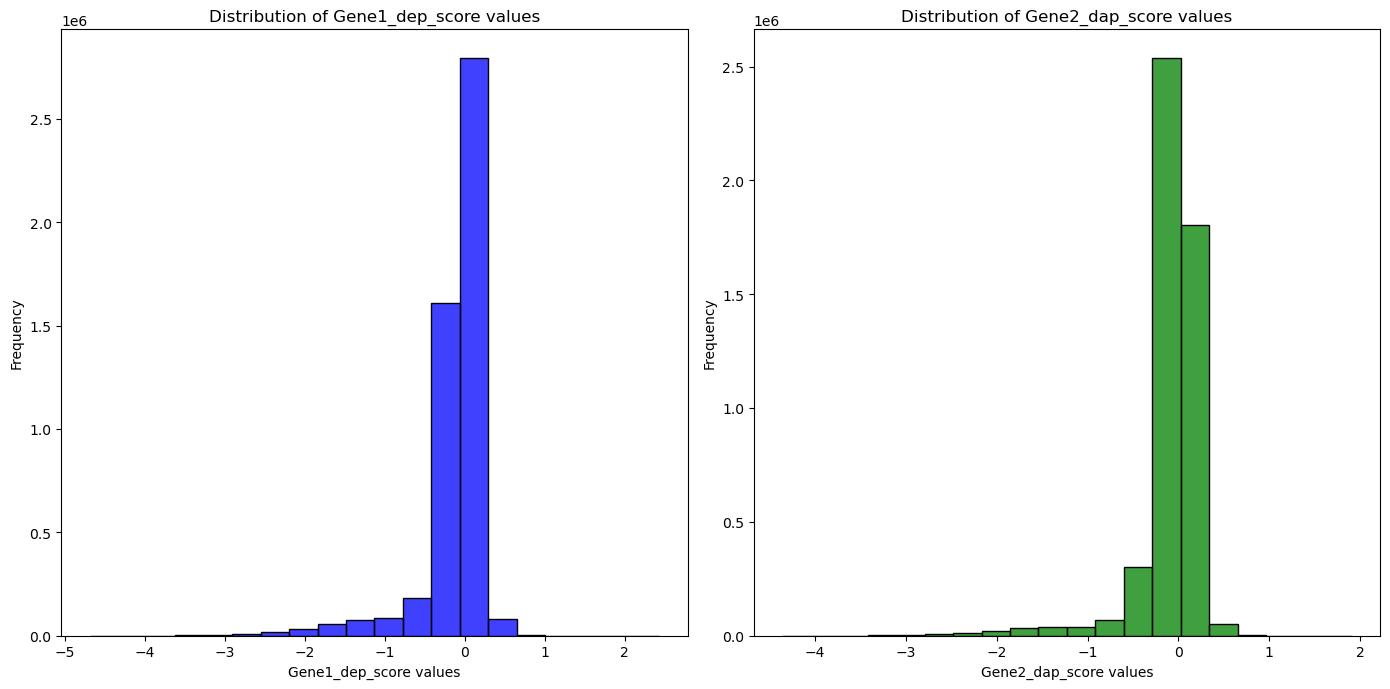

In [12]:
plot_depmap_distribution(
    final_expression_dep,
    gene1_col='Gene1_dep_score',
    gene2_col='Gene2_dap_score',
    figsize=(14, 7),
    bins=20,
    colors=('blue', 'green')
)


Extract cell lines spicific depadancy score 

In [13]:
# List of cell lines to extract
cell_lines_to_extract = ['ACH-000881', 'ACH-000219']

# Filter the data
cell_line_dep = filter_cell_lines(final_expression_dep, 'cell_line', cell_lines_to_extract)

# Define a dictionary to map old names to new names
cell_line_mapping = {
    "ACH-000881": "Meljuso",
    "ACH-000219": "A375"
}

# Replace the names in the 'cell_line' column
cell_line_dep['cell_line'] = cell_line_dep['cell_line'].replace(cell_line_mapping)

# Display the results
print(cell_line_dep)

        cell_line  Gene1_dep_score  Gene2_dap_score Gene_combination
129          A375        -0.517595        -1.235441       ACTB_ACTG1
590       Meljuso        -0.578683        -0.439853       ACTB_ACTG1
1279         A375        -0.147687        -0.034528      EOLA1_EOLA2
1740      Meljuso        -0.033131        -0.025609      EOLA1_EOLA2
2429         A375        -0.317584        -0.313067    RABL2A_RABL2B
...           ...              ...              ...              ...
5008840   Meljuso        -0.275849         0.092015    ZBTB12_ZBTB26
5009529      A375         0.026442         0.063486     ZNF41_ZNF517
5009990   Meljuso         0.131119        -0.031300     ZNF41_ZNF517
5010679      A375        -0.405896         0.094495    PTDSS1_PTDSS2
5011140   Meljuso        -1.074112        -0.003958    PTDSS1_PTDSS2

[8716 rows x 4 columns]


/tmp/ipykernel_3247/2795803292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_line_dep['cell_line'] = cell_line_dep['cell_line'].replace(cell_line_mapping)


Plot cell_line depadancy score 

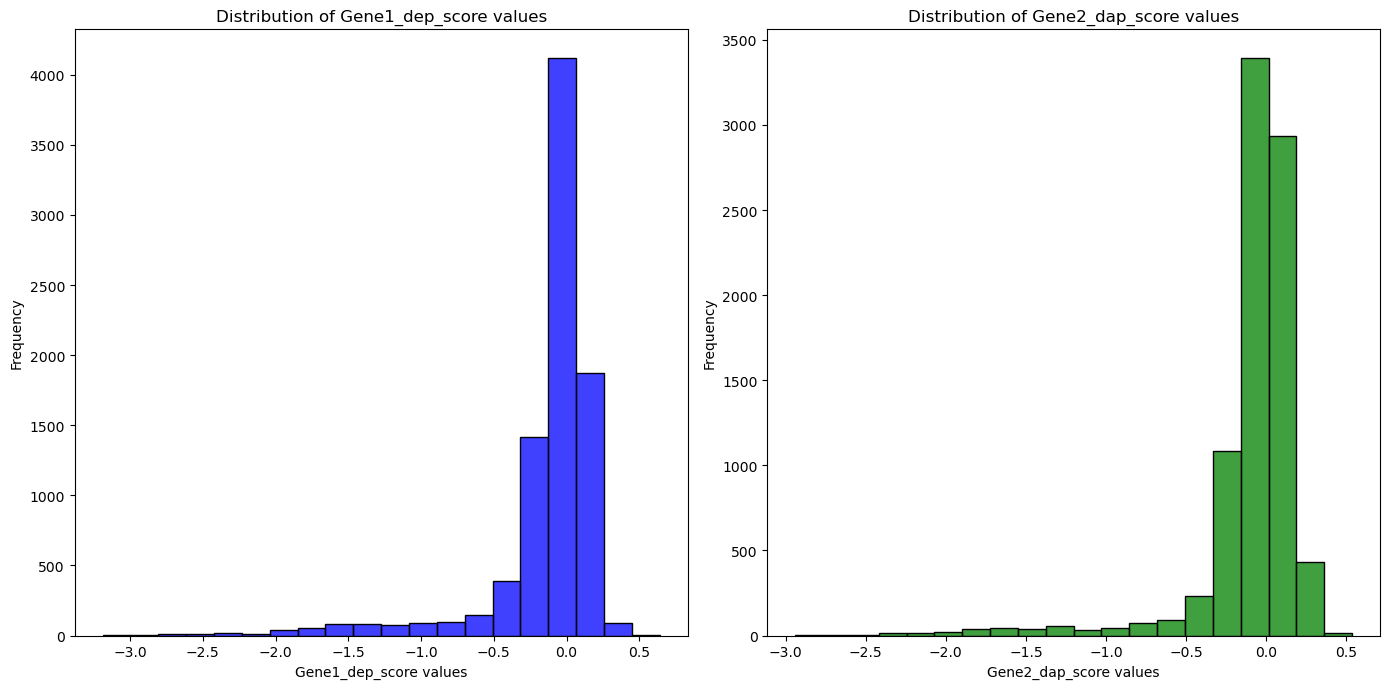

In [14]:
plot_depmap_distribution(
    cell_line_dep,
    gene1_col='Gene1_dep_score',
    gene2_col='Gene2_dap_score',
    figsize=(14, 7),
    bins=20,
    colors=('blue', 'green')
)

Calculate the Euclidean_distance as feature wihch reprecent both feature 

​
 


In [15]:

# Call the general function to calculate Euclidean distance
cell_line_dep = add_euclidean_distance(cell_line_dep, 'Gene1_dep_score', 'Gene2_dap_score', 'Euclidean_distance_dep')

# Display the DataFrame with the new column
print(cell_line_dep)

        cell_line  Gene1_dep_score  Gene2_dap_score Gene_combination  \
129          A375        -0.517595        -1.235441       ACTB_ACTG1   
590       Meljuso        -0.578683        -0.439853       ACTB_ACTG1   
1279         A375        -0.147687        -0.034528      EOLA1_EOLA2   
1740      Meljuso        -0.033131        -0.025609      EOLA1_EOLA2   
2429         A375        -0.317584        -0.313067    RABL2A_RABL2B   
...           ...              ...              ...              ...   
5008840   Meljuso        -0.275849         0.092015    ZBTB12_ZBTB26   
5009529      A375         0.026442         0.063486     ZNF41_ZNF517   
5009990   Meljuso         0.131119        -0.031300     ZNF41_ZNF517   
5010679      A375        -0.405896         0.094495    PTDSS1_PTDSS2   
5011140   Meljuso        -1.074112        -0.003958    PTDSS1_PTDSS2   

         Euclidean_distance_dep  
129                    0.717846  
590                    0.138830  
1279                   0.113159  

/tmp/ipykernel_3247/2343873044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col_name] = abs(df[col1] - df[col2])


Calculate Pearson correlation coefficient for inzolia libraly acrooss cell line

In [16]:
# Call the function
correlation_results_dep = calculate_grouped_correlation(
    df=final_expression_dep,
    group_col='Gene_combination',
    x_col='Gene1_dep_score',
    y_col='Gene2_dap_score'
)

# Display the results
print(correlation_results_dep)

     Gene_combination  Correlation   p_value
0          AAK1_BMP2K    -0.013799  0.640159
1         AARS1_AARS2     0.002442  0.934072
2         ABCA2_ABCA3     0.058724  0.046482
3         ABCA2_ABCA7     0.130127  0.000010
4         ABCA3_ABCA7     0.083512  0.004598
...               ...          ...       ...
4353  ZSCAN30_ZSCAN31    -0.006736  0.819499
4354   ZSCAN30_ZSCAN9    -0.006656  0.821599
4355   ZSCAN31_ZSCAN9     0.037240  0.206976
4356    ZSWIM4_ZSWIM6     0.031158  0.291094
4357        ZXDB_ZXDC    -0.049997  0.090135

[4358 rows x 3 columns]


# Open feature ducument to add the new feature  

In [17]:
file_path_sum = "/home/user/Desktop/2024_08_29/2024_08_27_gis_no_gis_no_gap_plus_lol.txt"
df_sum = pd.read_csv(file_path_sum, sep='\t')

# Rename the column 'class_label ' to 'class_label_sum' to easy comparstion
df_sum = df_sum.rename(columns={'Class_label': 'Class_label_sum'})

# Display the DataFrame
df_sum


,Unnamed: 0,cell_line,condition,Gene_combination,combinatorial_avg_lfc,single_gene1_avg_lfc,single_gene2_avg_lfc,expression_gene1_batch_correct,expression_gene2_batch_correct,Class_label_sum
0,0,A375,2CP,AAK1_BMP2K,-1.323147,-0.986385,-0.524813,2.678502,1.908314,no GI
1,1,A375,2CP,AARS1_AARS2,-4.733963,-4.557785,-2.982134,7.264065,3.454373,lol
2,2,A375,2CP,ABCA2_ABCA3,0.234114,-0.005448,-0.717969,4.184355,0.094743,no GI
3,3,A375,2CP,ABCA2_ABCA7,-0.228554,-0.005448,0.141434,4.184355,1.704554,no GI
4,4,A375,2CP,ABCA3_ABCA7,-0.540774,-0.717969,0.141434,0.094743,1.704554,no GI
...,...,...,...,...,...,...,...,...,...,...
8714,8714,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.661490,0.242981,0.182299,2.621646,0.640470,no GI
8715,8715,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.273976,0.242981,0.642505,2.621646,2.892239,no GI
8716,8716,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.432295,0.182299,0.642505,0.640470,2.892239,no GI
8717,8717,Meljuso,2CP sel,ZSWIM4_ZSWIM6,-0.324097,0.165044,-0.601162,1.086040,2.185050,no GI


Transfer Correlation to df_sum 

i used left to both data. This method will join both data keep all raws from my original data df_sum and matched the column with the new data cell_line_dep

In [18]:
# Add corrlation matrix for depadancy score 
df_merge_cor = pd.merge(
    df_sum,
    correlation_results_dep[['Gene_combination', 'Correlation']],  
    on=['Gene_combination'],  
    how='left'  
)

 # Renaming a column Correlation
df_merge_cor.rename(columns={"Correlation": "dep_Correlation"}, inplace=True)




Transfer Euclidean_distance_dep to df_merge_corbased on cell_line and Gene_combination



In [19]:


# Add cell_line Euclidean_distance_dep matrix for depadancy score to df_merge 
df_merge_cor_d = pd.merge(
    df_merge_cor,
    cell_line_dep[['Gene_combination', 'cell_line', 'Euclidean_distance_dep','Gene1_dep_score','Gene2_dap_score']], 
    on=['Gene_combination', 'cell_line'], 
    how='left'  
)


Visualise the correlation of the depadancy score extracted features

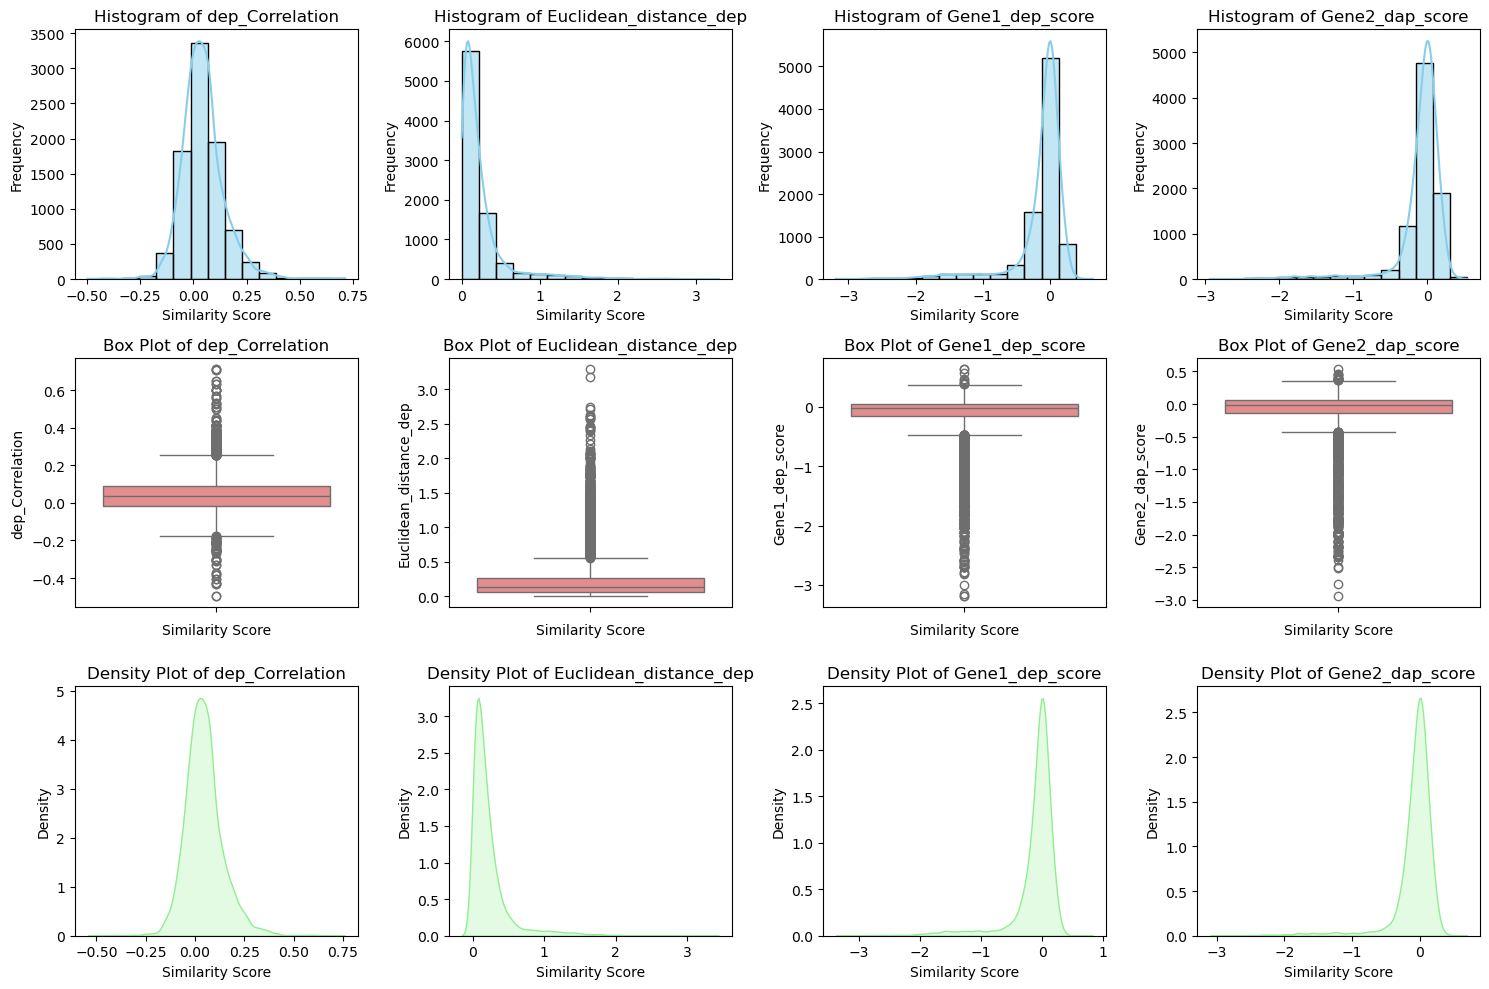

{'dep_Correlation': count    8657.000000
 mean        0.045232
 std         0.100001
 min        -0.495811
 25%        -0.015739
 50%         0.036690
 75%         0.091442
 max         0.712322
 Name: dep_Correlation, dtype: float64,
 'Euclidean_distance_dep': count    8406.000000
 mean        0.230804
 std         0.310460
 min         0.000028
 25%         0.062821
 50%         0.137388
 75%         0.261291
 max         3.296090
 Name: Euclidean_distance_dep, dtype: float64,
 'Gene1_dep_score': count    8553.000000
 mean       -0.132737
 std         0.398611
 min        -3.188866
 25%        -0.154746
 50%        -0.022614
 75%         0.057413
 max         0.640329
 Name: Gene1_dep_score, dtype: float64,
 'Gene2_dap_score': count    8503.000000
 mean       -0.089833
 std         0.332933
 min        -2.941176
 25%        -0.130211
 50%        -0.018822
 75%         0.066146
 max         0.537146
 Name: Gene2_dap_score, dtype: float64}

In [20]:
similarity_columns = ['dep_Correlation','Euclidean_distance_dep','Gene1_dep_score','Gene2_dap_score']
calculate_and_visualize_similarity_stats(df_merge_cor_d, similarity_columns)

# Using the Function Above to Extract gene exprestion values for Cell Line-Specific Data and Calculate the Correlation of Dependency Using the Inzolia Library

open the file of the exprestion 

In [21]:
file_path_expre= "/home/user/Desktop/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv"
df_expre= load_depmap_file(file_path_expre)

File loaded successfully: /home/user/Desktop/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected.csv


Extract RNA expresstion data that overlapp with inzolia libraly

In [22]:
# Call the function and unpack the tuple into two variables
final_expression_expre, missing_genes_df = process_gene_expression_data(
    df_expre, df_inz, 
    gene1_input_col="Gene1", 
    gene2_input_col="Gene2", 
    gene1_output_col="Gene1_expression", 
    gene2_output_col="Gene2_expression"
)

# Now you can use the DataFrames independently
print(final_expression_expre)
print(missing_genes_df)

          cell_line  Gene1_expression  Gene2_expression Gene_combination
0        ACH-000058         11.192051         11.328729       ACTB_ACTG1
1        ACH-000082         12.739343         11.145570       ACTB_ACTG1
2        ACH-000867         10.571643          9.839114       ACTB_ACTG1
3        ACH-000437         12.340807         11.277859       ACTB_ACTG1
4        ACH-000544         10.513251          9.981975       ACTB_ACTG1
...             ...               ...               ...              ...
6658108  ACH-001743          6.284228          5.015632    PTDSS1_PTDSS2
6658109  ACH-001578          5.491514          4.822039    PTDSS1_PTDSS2
6658110  ACH-002669          6.301047          3.990523    PTDSS1_PTDSS2
6658111  ACH-001858          5.687803          4.560714    PTDSS1_PTDSS2
6658112  ACH-001997          5.777899          3.921905    PTDSS1_PTDSS2

[6658113 rows x 4 columns]
Empty DataFrame
Columns: [Gene_combination, Gene1, Gene2, Missing_Genes]
Index: []


PLot the distription of the exprestion 

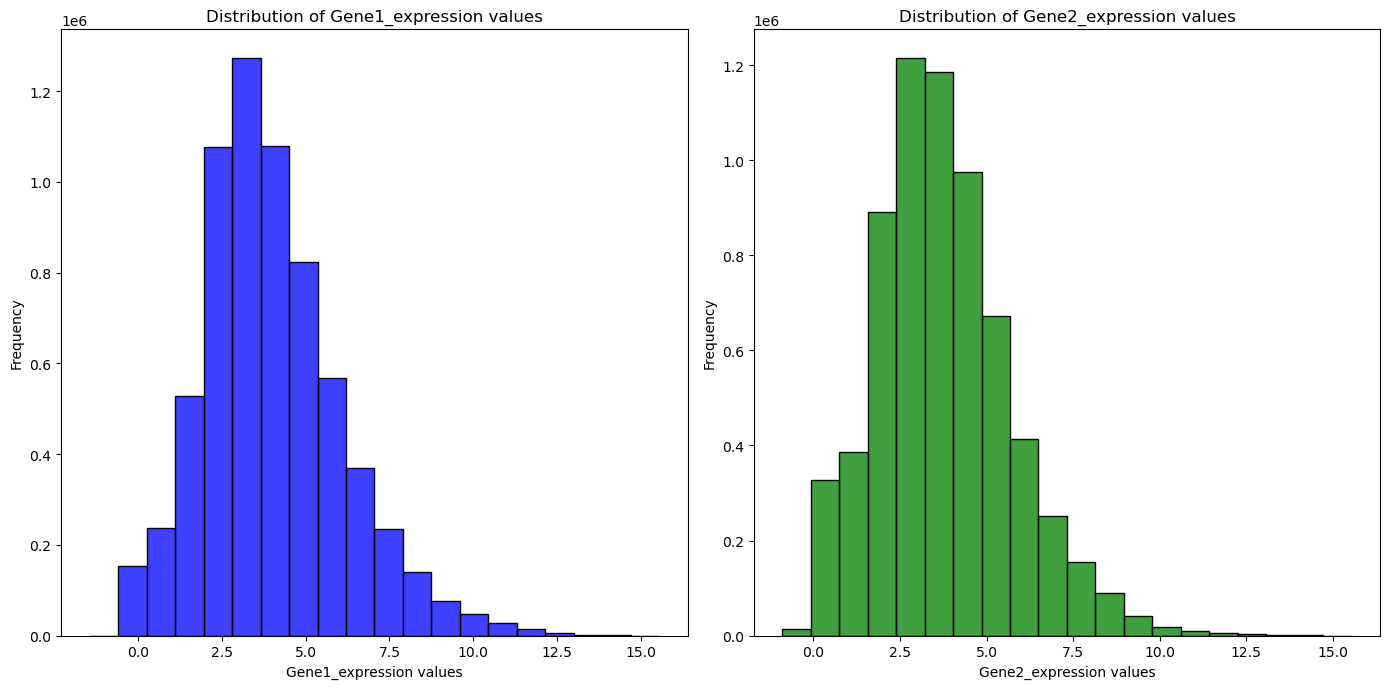

In [24]:
plot_depmap_distribution(
    final_expression_expre,
    gene1_col='Gene1_expression',
    gene2_col='Gene2_expression',
    figsize=(14, 7),
    bins=20,
    colors=('blue', 'green')
)


Extract cell line spisific exprestion for RNA exprestion

In [ ]:
# List of cell lines to extract
cell_lines_to_extract = ['ACH-000881', 'ACH-000219']

# Filter the data
cell_line_expre = filter_cell_lines(final_expression_expre, 'cell_line', cell_lines_to_extract)

# Define a dictionary to map old names to new names
cell_line_mapping = {
    "ACH-000881": "Meljuso",
    "ACH-000219": "A375"
}

# Replace the names in the 'cell_line' column
cell_line_expre['cell_line'] = cell_line_expre['cell_line'].replace(cell_line_mapping)

# Display the results
print(cell_line_expre)

        cell_line  Gene1_expression  Gene2_expression Gene_combination
98        Meljuso         12.045879         10.395898       ACTB_ACTG1
378          A375         10.671716         10.231803       ACTB_ACTG1
1615      Meljuso          3.944236          5.134629      EOLA1_EOLA2
1895         A375          3.299950          4.688617      EOLA1_EOLA2
3132      Meljuso          2.345910          3.517736    RABL2A_RABL2B
...           ...               ...               ...              ...
6653940      A375          2.749525          2.821706    ZBTB12_ZBTB26
6655177   Meljuso          1.794410          1.948954     ZNF41_ZNF517
6655457      A375          2.420489          1.775766     ZNF41_ZNF517
6656694   Meljuso          6.291282          4.331141    PTDSS1_PTDSS2
6656974      A375          5.907472          3.415920    PTDSS1_PTDSS2

[8778 rows x 4 columns]


/tmp/ipykernel_2426/3679144580.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_line_expre['cell_line'] = cell_line_expre['cell_line'].replace(cell_line_mapping)


Calculate the Euclidean_distance as feature wihch reprecent both feature 

In [ ]:
# Call the general function to calculate Euclidean distance
cell_line_expre = add_euclidean_distance(cell_line_expre, 'Gene1_expression', 'Gene2_expression', 'Euclidean_distance_expresstion')

# Display the DataFrame with the new column
print(cell_line_expre)

        cell_line  Gene1_expression  Gene2_expression Gene_combination  \
98        Meljuso         12.045879         10.395898       ACTB_ACTG1   
378          A375         10.671716         10.231803       ACTB_ACTG1   
1615      Meljuso          3.944236          5.134629      EOLA1_EOLA2   
1895         A375          3.299950          4.688617      EOLA1_EOLA2   
3132      Meljuso          2.345910          3.517736    RABL2A_RABL2B   
...           ...               ...               ...              ...   
6653940      A375          2.749525          2.821706    ZBTB12_ZBTB26   
6655177   Meljuso          1.794410          1.948954     ZNF41_ZNF517   
6655457      A375          2.420489          1.775766     ZNF41_ZNF517   
6656694   Meljuso          6.291282          4.331141    PTDSS1_PTDSS2   
6656974      A375          5.907472          3.415920    PTDSS1_PTDSS2   

         Euclidean_distance_expresstion  
98                             1.649981  
378                        

/tmp/ipykernel_2426/3890092052.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, new_col_name] = np.sqrt((df[col1] - df[col2]) ** 2)


Calculate Pearson correlation coefficient for inzolia libraly acrooss cell line

In [ ]:
# Call the function
correlation_results_expre = calculate_grouped_correlation(
    df=final_expression_expre,
    group_col='Gene_combination',
    x_col='Gene1_expression',
    y_col='Gene2_expression'
)

# Display the results
print(correlation_results_expre)

     Gene_combination  Correlation       p_value
0          AAK1_BMP2K     0.159615  4.057377e-10
1         AARS1_AARS2     0.132821  2.081149e-07
2         ABCA2_ABCA3     0.326935  4.042310e-39
3         ABCA2_ABCA7     0.086174  7.798271e-04
4         ABCA3_ABCA7     0.063370  1.356334e-02
...               ...          ...           ...
4384  ZSCAN30_ZSCAN31     0.025340  3.239824e-01
4385   ZSCAN30_ZSCAN9     0.280711  7.222388e-29
4386   ZSCAN31_ZSCAN9     0.196111  1.289064e-14
4387    ZSWIM4_ZSWIM6     0.281455  5.108107e-29
4388        ZXDB_ZXDC     0.322427  4.888487e-38

[4389 rows x 3 columns]


Merge correlation result of the exprestion

In [ ]:

# Merge df_merge_cor_d to correlation_results_expre
df_merge_cor_d_expc = pd.merge(
    df_merge_cor_d,
    correlation_results_expre[['Gene_combination', 'Correlation']], 
    on=['Gene_combination'], 
    how='left'  
)

# Renaming a column Correlation
df_merge_cor_d_expc.rename(columns={"Correlation": "expre_Correlation"}, inplace=True)


In [ ]:
df_merge_cor_d_expc 


,Unnamed: 0,cell_line,condition,Gene_combination,combinatorial_avg_lfc,single_gene1_avg_lfc,single_gene2_avg_lfc,expression_gene1_batch_correct,expression_gene2_batch_correct,Class_label_sum,dep_Correlation,Euclidean_distance_dep,Gene1_dep_score,Gene2_dap_score,expre_Correlation
0,0,A375,2CP,AAK1_BMP2K,-1.323147,-0.986385,-0.524813,2.678502,1.908314,no GI,-0.013799,0.044805,-0.170045,-0.125240,0.159615
1,1,A375,2CP,AARS1_AARS2,-4.733963,-4.557785,-2.982134,7.264065,3.454373,lol,0.002442,1.047254,-1.814641,-0.767387,0.132821
2,2,A375,2CP,ABCA2_ABCA3,0.234114,-0.005448,-0.717969,4.184355,0.094743,no GI,0.058724,0.117032,0.080063,0.197095,0.326935
3,3,A375,2CP,ABCA2_ABCA7,-0.228554,-0.005448,0.141434,4.184355,1.704554,no GI,0.130127,0.102892,0.080063,0.182956,0.086174
4,4,A375,2CP,ABCA3_ABCA7,-0.540774,-0.717969,0.141434,0.094743,1.704554,no GI,0.083512,0.014140,0.197095,0.182956,0.063370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,8714,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.661490,0.242981,0.182299,2.621646,0.640470,no GI,-0.006736,0.105474,0.012371,0.117846,0.025340
8715,8715,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.273976,0.242981,0.642505,2.621646,2.892239,no GI,-0.006656,0.078652,0.012371,0.091024,0.280711
8716,8716,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.432295,0.182299,0.642505,0.640470,2.892239,no GI,0.037240,0.026822,0.117846,0.091024,0.196111
8717,8717,Meljuso,2CP sel,ZSWIM4_ZSWIM6,-0.324097,0.165044,-0.601162,1.086040,2.185050,no GI,0.031158,0.267009,-0.086476,0.180533,0.281455


Add cell line spisific depadancy to matrix

In [ ]:

# Merge cell_line Euclidean_distance_expresstion 
df_merge_cor_d_expc_d = pd.merge(
    df_merge_cor_d_expc,
    cell_line_expre[['Gene_combination', 'cell_line', 'Euclidean_distance_expresstion','Gene1_expression','Gene2_expression']], 
    on=['Gene_combination', 'cell_line'], 
    how='left'  
)


In [ ]:
df_merge_cor_d_expc_d

,Unnamed: 0,cell_line,condition,Gene_combination,combinatorial_avg_lfc,single_gene1_avg_lfc,single_gene2_avg_lfc,expression_gene1_batch_correct,expression_gene2_batch_correct,Class_label_sum,dep_Correlation,Euclidean_distance_dep,Gene1_dep_score,Gene2_dap_score,expre_Correlation,Euclidean_distance_expresstion,Gene1_expression,Gene2_expression
0,0,A375,2CP,AAK1_BMP2K,-1.323147,-0.986385,-0.524813,2.678502,1.908314,no GI,-0.013799,0.044805,-0.170045,-0.125240,0.159615,0.770189,2.678502,1.908314
1,1,A375,2CP,AARS1_AARS2,-4.733963,-4.557785,-2.982134,7.264065,3.454373,lol,0.002442,1.047254,-1.814641,-0.767387,0.132821,3.809692,7.264065,3.454373
2,2,A375,2CP,ABCA2_ABCA3,0.234114,-0.005448,-0.717969,4.184355,0.094743,no GI,0.058724,0.117032,0.080063,0.197095,0.326935,4.089612,4.184355,0.094743
3,3,A375,2CP,ABCA2_ABCA7,-0.228554,-0.005448,0.141434,4.184355,1.704554,no GI,0.130127,0.102892,0.080063,0.182956,0.086174,2.479801,4.184355,1.704554
4,4,A375,2CP,ABCA3_ABCA7,-0.540774,-0.717969,0.141434,0.094743,1.704554,no GI,0.083512,0.014140,0.197095,0.182956,0.063370,1.609811,0.094743,1.704554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,8714,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.661490,0.242981,0.182299,2.621646,0.640470,no GI,-0.006736,0.105474,0.012371,0.117846,0.025340,1.981177,2.621646,0.640470
8715,8715,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.273976,0.242981,0.642505,2.621646,2.892239,no GI,-0.006656,0.078652,0.012371,0.091024,0.280711,0.270592,2.621646,2.892239
8716,8716,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.432295,0.182299,0.642505,0.640470,2.892239,no GI,0.037240,0.026822,0.117846,0.091024,0.196111,2.251769,0.640470,2.892239
8717,8717,Meljuso,2CP sel,ZSWIM4_ZSWIM6,-0.324097,0.165044,-0.601162,1.086040,2.185050,no GI,0.031158,0.267009,-0.086476,0.180533,0.281455,1.099011,1.086040,2.185050


Visualise the exprestion extracted values

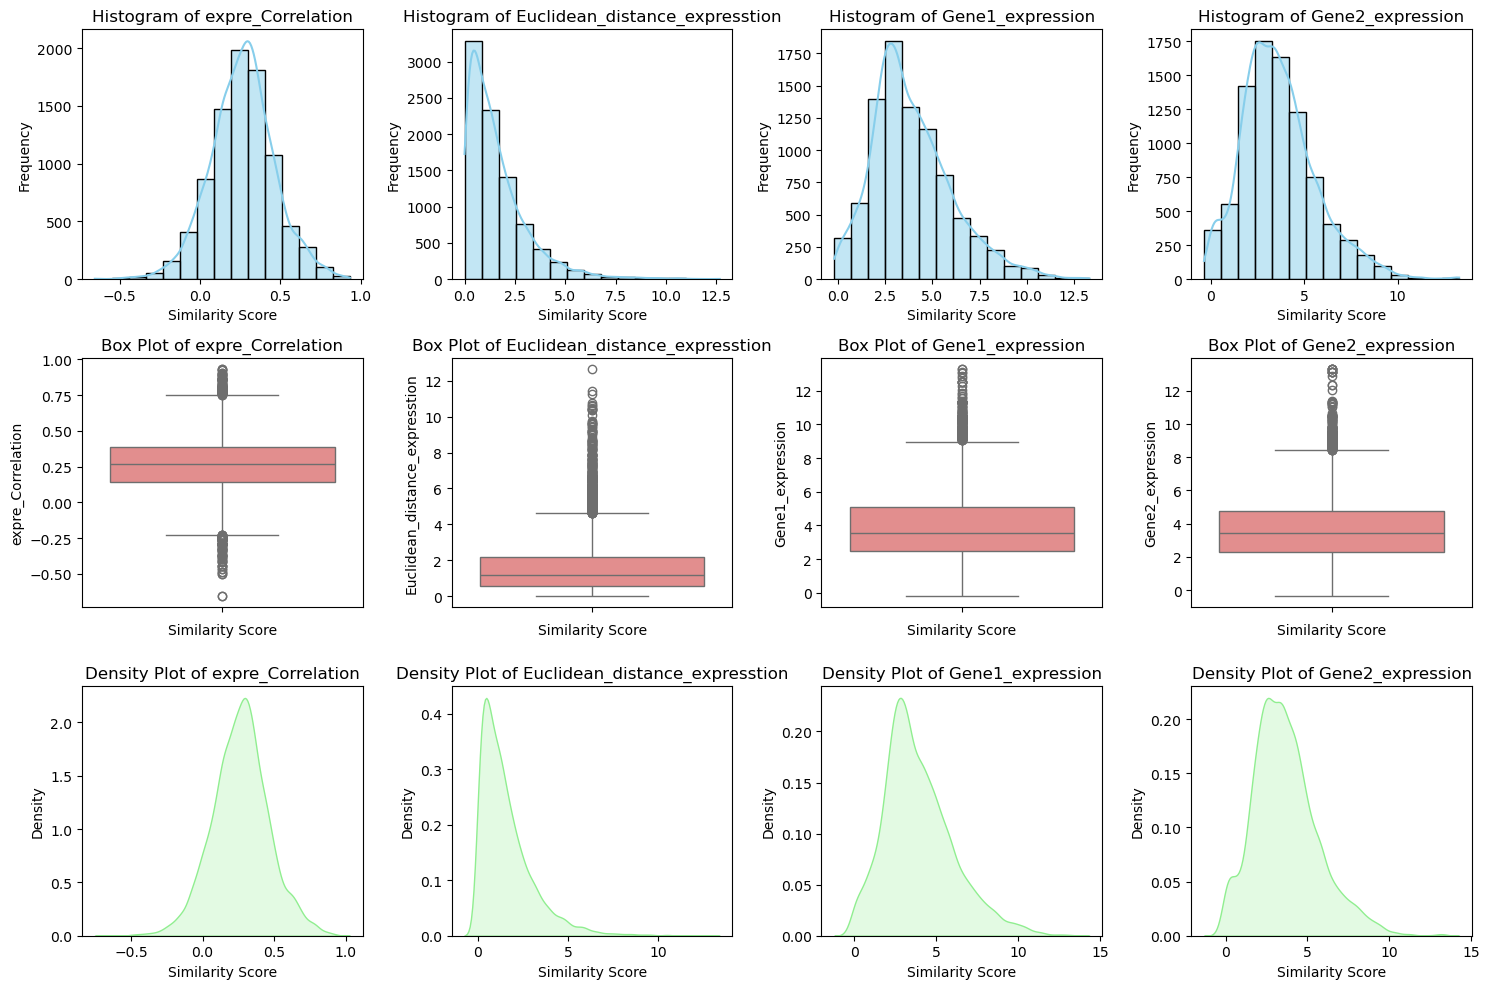

{'expre_Correlation': count    8719.000000
 mean        0.264344
 std         0.199396
 min        -0.655539
 25%         0.139527
 50%         0.269494
 75%         0.384668
 max         0.932781
 Name: expre_Correlation, dtype: float64,
 'Euclidean_distance_expresstion': count    8719.000000
 mean        1.594108
 std         1.478911
 min         0.000019
 25%         0.541816
 50%         1.198726
 75%         2.182384
 max        12.660645
 Name: Euclidean_distance_expresstion, dtype: float64,
 'Gene1_expression': count    8719.000000
 mean        3.917946
 std         2.127669
 min        -0.194501
 25%         2.477983
 50%         3.526132
 75%         5.105409
 max        13.296116
 Name: Gene1_expression, dtype: float64,
 'Gene2_expression': count    8719.000000
 mean        3.670675
 std         1.994863
 min        -0.352529
 25%         2.296952
 50%         3.426827
 75%         4.748324
 max        13.296116
 Name: Gene2_expression, dtype: float64}

In [ ]:
similarity_columns = ['expre_Correlation','Euclidean_distance_expresstion','Gene1_expression','Gene2_expression']
calculate_and_visualize_similarity_stats(df_merge_cor_d_expc_d, similarity_columns)

# Extract damage mutation 

# Download the file
OmicsSomaticMutationsMatrixDamaging.csv

# Describtion of the file content from depmap 
"Genotyped matrix determining for each cell line whether each gene has at least one damaging mutation.

A variant is considered a damaging mutation if LikelyLoF == True. (0 == no mutation; If there is one or more damaging mutations in the same gene for the same cell line, the allele frequencies are summed, and if the sum is greater than 0.95, a value of 2 is assigned and if not, a value of 1 is assigned.)"


In [ ]:
file_path_dm= "/home/user/Desktop/OmicsSomaticMutationsMatrixDamaging.csv"
df_dm= load_depmap_file(file_path_dm)

File loaded successfully: /home/user/Desktop/OmicsSomaticMutationsMatrixDamaging.csv


Extract the gene that overlapp with inzolia libraly 

In [ ]:
# Call the function and unpack the tuple into two variables
final_expression_dm, missing_genes_df = process_gene_expression_data(
    df_dm, df_inz, 
    gene1_input_col="Gene1", 
    gene2_input_col="Gene2", 
    gene1_output_col="Gene1_damage_mutation", 
    gene2_output_col="Gene2_damage_mutation"
)

# Now you can use the DataFrames independently
print(final_expression_dm)
print(missing_genes_df)

Genes not found for Gene_combination EOLA1_EOLA2: EOLA1, EOLA2
Genes not found for Gene_combination RABL2A_RABL2B: RABL2A, RABL2B
Genes not found for Gene_combination H2BC11_H2BC4: H2BC4
Genes not found for Gene_combination MYL12A_MYL12B: MYL12B
Genes not found for Gene_combination AGAP4_AGAP6: AGAP4, AGAP6
Genes not found for Gene_combination H2AZ1_H2AZ2: H2AZ1
Genes not found for Gene_combination SRGAP2B_SRGAP2C: SRGAP2B, SRGAP2C
Genes not found for Gene_combination AGAP4_AGAP5: AGAP4, AGAP5
Genes not found for Gene_combination TUBB2B_TUBB4B: TUBB2B
Genes not found for Gene_combination RPS27_RPS27L: RPS27
Genes not found for Gene_combination TUBB2A_TUBB4B: TUBB2A
Genes not found for Gene_combination AGAP5_AGAP6: AGAP5, AGAP6
Genes not found for Gene_combination MZT2A_MZT2B: MZT2B
Genes not found for Gene_combination ARF1_ARF3: ARF3
Genes not found for Gene_combination MAGEA3_MAGEA6: MAGEA3, MAGEA6
Genes not found for Gene_combination TUBB_TUBB2B: TUBB2B
Genes not found for Gene_combi

plot the distruption of damage mutation

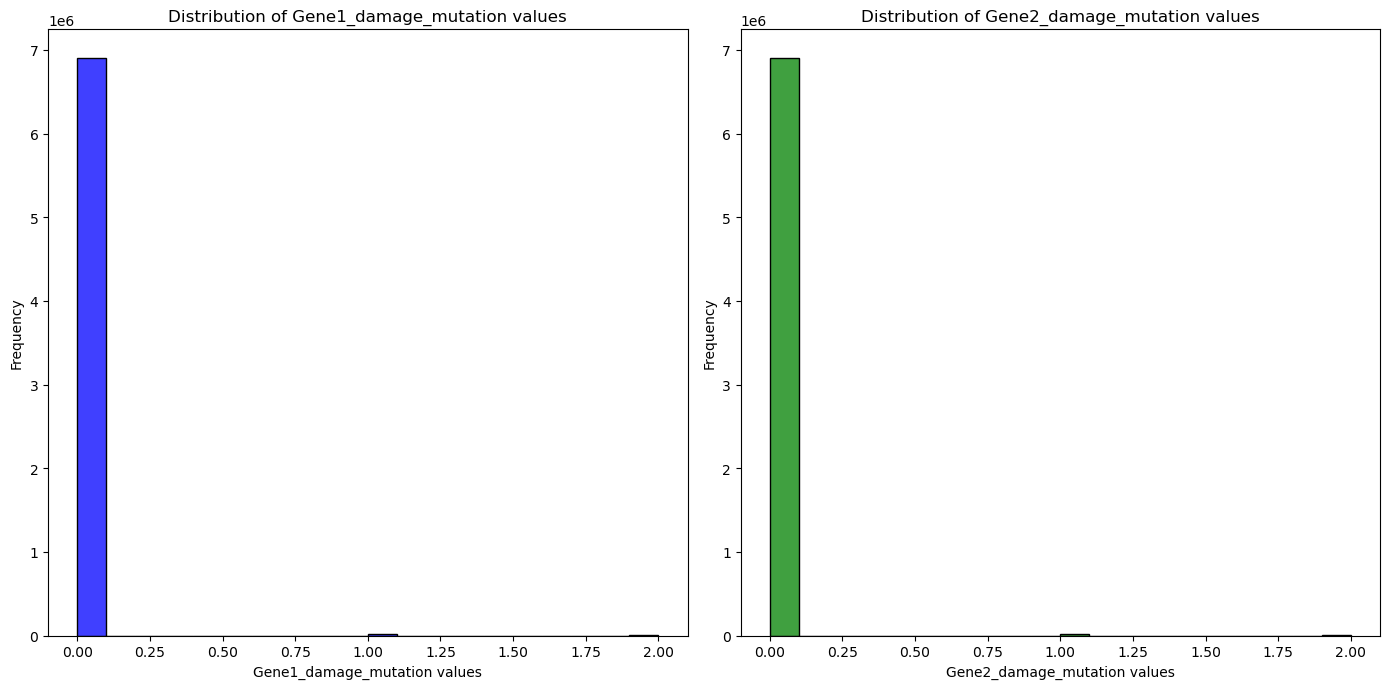

In [ ]:
plot_depmap_distribution(
    final_expression_dm,
    gene1_col='Gene1_damage_mutation',
    gene2_col='Gene2_damage_mutation',
    figsize=(14, 7),
    bins=20,
    colors=('blue', 'green')
)


Extract ceel line spsific damage score

In [ ]:
# List of cell lines to extract
cell_lines_to_extract = ['ACH-000881', 'ACH-000219']

# Filter the data
cell_line_dm = filter_cell_lines(final_expression_dm, 'cell_line', cell_lines_to_extract)

# Define a dictionary to map old names to new names
cell_line_mapping = {
    "ACH-000881": "Meljuso",
    "ACH-000219": "A375"
}

# Replace the names in the 'cell_line' column
cell_line_dm['cell_line'] = cell_line_dm['cell_line'].replace(cell_line_mapping)

# Display the results
print(cell_line_dm)

        cell_line  Gene1_damage_mutation  Gene2_damage_mutation  \
455          A375                    0.0                    0.0   
1197      Meljuso                    0.0                    0.0   
2243         A375                    0.0                    0.0   
2985      Meljuso                    0.0                    0.0   
4031         A375                    0.0                    0.0   
...           ...                    ...                    ...   
6918969   Meljuso                    0.0                    0.0   
6920015      A375                    0.0                    0.0   
6920757   Meljuso                    0.0                    0.0   
6921803      A375                    0.0                    0.0   
6922545   Meljuso                    0.0                    0.0   

        Gene_combination  
455           ACTB_ACTG1  
1197          ACTB_ACTG1  
2243       RPL26_RPL26L1  
2985       RPL26_RPL26L1  
4031       CDK11A_CDK11B  
...                  ...  
691896

/tmp/ipykernel_2426/3331952792.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_line_dm['cell_line'] = cell_line_dm['cell_line'].replace(cell_line_mapping)


Calculate the Euclidean_distance as feature wihch reprecent both feature 

In [ ]:
# Call the general function to calculate Euclidean distance
cell_line_dm = add_euclidean_distance(cell_line_dm, 'Gene1_damage_mutation', 'Gene2_damage_mutation', 'Euclidean_distance_dm')

# Display the DataFrame with the new column
print(cell_line_dm)

        cell_line  Gene1_damage_mutation  Gene2_damage_mutation  \
455          A375                    0.0                    0.0   
1197      Meljuso                    0.0                    0.0   
2243         A375                    0.0                    0.0   
2985      Meljuso                    0.0                    0.0   
4031         A375                    0.0                    0.0   
...           ...                    ...                    ...   
6918969   Meljuso                    0.0                    0.0   
6920015      A375                    0.0                    0.0   
6920757   Meljuso                    0.0                    0.0   
6921803      A375                    0.0                    0.0   
6922545   Meljuso                    0.0                    0.0   

        Gene_combination  Euclidean_distance_dm  
455           ACTB_ACTG1                    0.0  
1197          ACTB_ACTG1                    0.0  
2243       RPL26_RPL26L1                    0

/tmp/ipykernel_2426/3890092052.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, new_col_name] = np.sqrt((df[col1] - df[col2]) ** 2)


# Merge to frature dataframe

In [ ]:

# Merge cell_line Euclidean_distance_expresstion 
df_merge_cor_d_expc_d_dm = pd.merge(
    df_merge_cor_d_expc_d,
    cell_line_dm[['Gene_combination', 'cell_line', 'Euclidean_distance_dm','Gene1_damage_mutation','Gene2_damage_mutation',]], 
    on=['Gene_combination', 'cell_line'], 
    how='left'  
)

In [ ]:
df_merge_cor_d_expc_d_dm

,Unnamed: 0,cell_line,condition,Gene_combination,combinatorial_avg_lfc,single_gene1_avg_lfc,single_gene2_avg_lfc,expression_gene1_batch_correct,expression_gene2_batch_correct,Class_label_sum,...,Euclidean_distance_dep,Gene1_dep_score,Gene2_dap_score,expre_Correlation,Euclidean_distance_expresstion,Gene1_expression,Gene2_expression,Euclidean_distance_dm,Gene1_damage_mutation,Gene2_damage_mutation
0,0,A375,2CP,AAK1_BMP2K,-1.323147,-0.986385,-0.524813,2.678502,1.908314,no GI,...,0.044805,-0.170045,-0.125240,0.159615,0.770189,2.678502,1.908314,0.0,0.0,0.0
1,1,A375,2CP,AARS1_AARS2,-4.733963,-4.557785,-2.982134,7.264065,3.454373,lol,...,1.047254,-1.814641,-0.767387,0.132821,3.809692,7.264065,3.454373,0.0,0.0,0.0
2,2,A375,2CP,ABCA2_ABCA3,0.234114,-0.005448,-0.717969,4.184355,0.094743,no GI,...,0.117032,0.080063,0.197095,0.326935,4.089612,4.184355,0.094743,0.0,0.0,0.0
3,3,A375,2CP,ABCA2_ABCA7,-0.228554,-0.005448,0.141434,4.184355,1.704554,no GI,...,0.102892,0.080063,0.182956,0.086174,2.479801,4.184355,1.704554,0.0,0.0,0.0
4,4,A375,2CP,ABCA3_ABCA7,-0.540774,-0.717969,0.141434,0.094743,1.704554,no GI,...,0.014140,0.197095,0.182956,0.063370,1.609811,0.094743,1.704554,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,8714,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.661490,0.242981,0.182299,2.621646,0.640470,no GI,...,0.105474,0.012371,0.117846,0.025340,1.981177,2.621646,0.640470,0.0,0.0,0.0
8715,8715,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.273976,0.242981,0.642505,2.621646,2.892239,no GI,...,0.078652,0.012371,0.091024,0.280711,0.270592,2.621646,2.892239,0.0,0.0,0.0
8716,8716,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.432295,0.182299,0.642505,0.640470,2.892239,no GI,...,0.026822,0.117846,0.091024,0.196111,2.251769,0.640470,2.892239,0.0,0.0,0.0
8717,8717,Meljuso,2CP sel,ZSWIM4_ZSWIM6,-0.324097,0.165044,-0.601162,1.086040,2.185050,no GI,...,0.267009,-0.086476,0.180533,0.281455,1.099011,1.086040,2.185050,0.0,0.0,0.0


# Visualise the distripution of damage mutation 

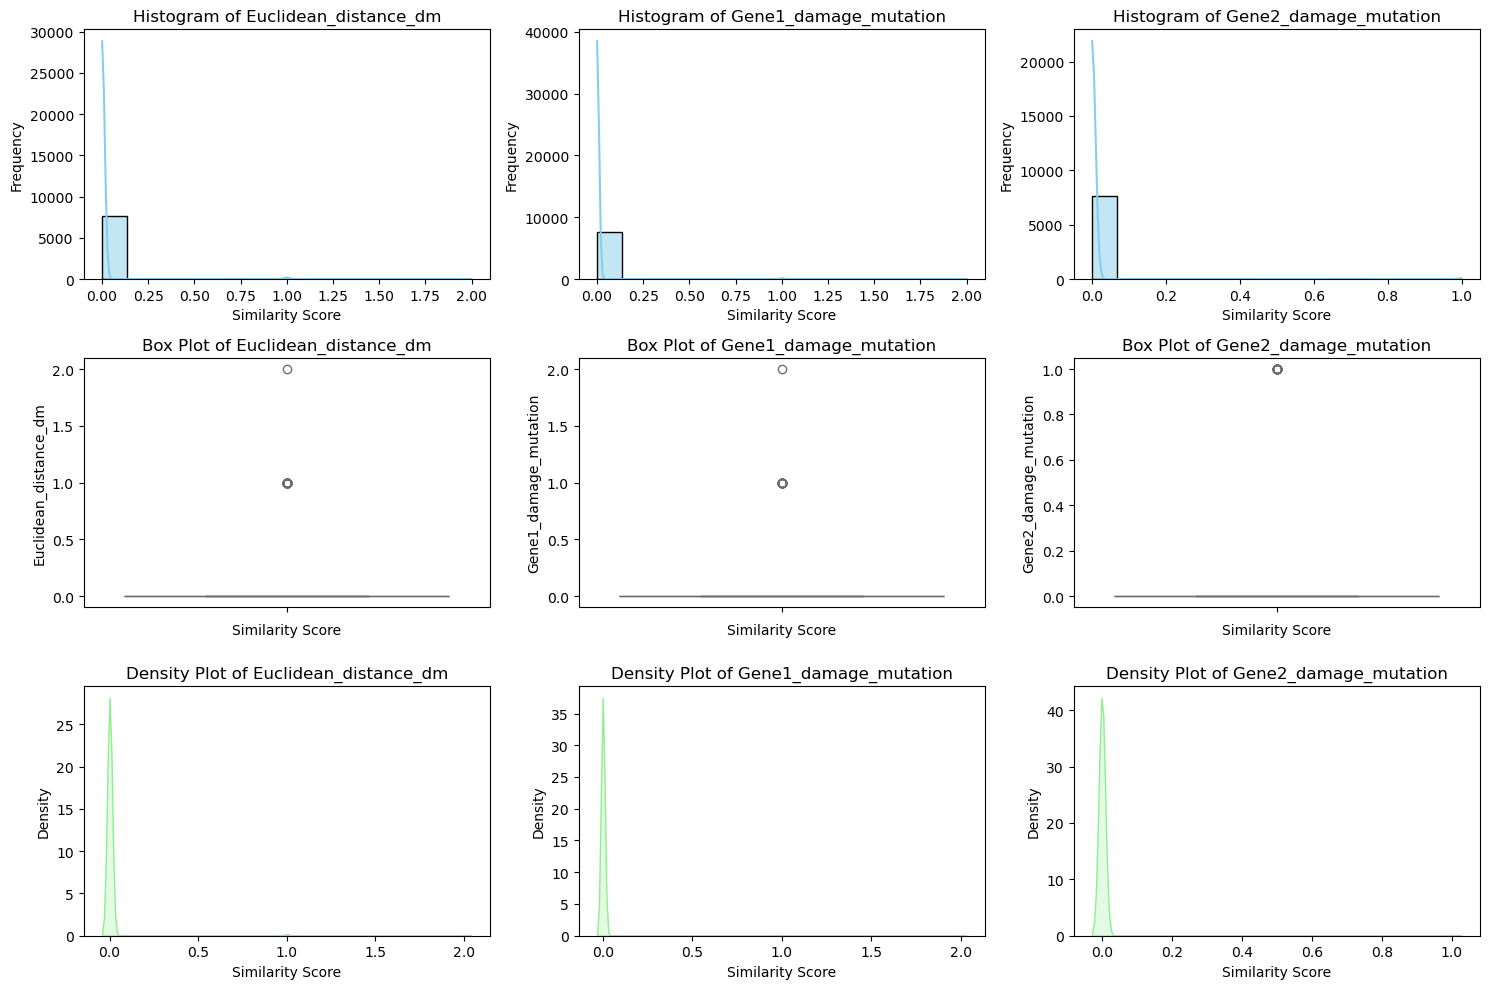

{'Euclidean_distance_dm': count    7687.000000
 mean        0.006895
 std         0.084311
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         2.000000
 Name: Euclidean_distance_dm, dtype: float64,
 'Gene1_damage_mutation': count    7687.000000
 mean        0.003773
 std         0.063396
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         2.000000
 Name: Gene1_damage_mutation, dtype: float64,
 'Gene2_damage_mutation': count    7687.000000
 mean        0.003122
 std         0.055793
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         1.000000
 Name: Gene2_damage_mutation, dtype: float64}

In [ ]:
similarity_columns = ['Euclidean_distance_dm','Gene1_damage_mutation','Gene2_damage_mutation']
calculate_and_visualize_similarity_stats(df_merge_cor_d_expc_d_dm, similarity_columns)

In [ ]:
df_merge_cor_d_expc_d_dm

,Unnamed: 0,cell_line,condition,Gene_combination,combinatorial_avg_lfc,single_gene1_avg_lfc,single_gene2_avg_lfc,expression_gene1_batch_correct,expression_gene2_batch_correct,Class_label_sum,...,Euclidean_distance_dep,Gene1_dep_score,Gene2_dap_score,expre_Correlation,Euclidean_distance_expresstion,Gene1_expression,Gene2_expression,Euclidean_distance_dm,Gene1_damage_mutation,Gene2_damage_mutation
0,0,A375,2CP,AAK1_BMP2K,-1.323147,-0.986385,-0.524813,2.678502,1.908314,no GI,...,0.044805,-0.170045,-0.125240,0.159615,0.770189,2.678502,1.908314,0.0,0.0,0.0
1,1,A375,2CP,AARS1_AARS2,-4.733963,-4.557785,-2.982134,7.264065,3.454373,lol,...,1.047254,-1.814641,-0.767387,0.132821,3.809692,7.264065,3.454373,0.0,0.0,0.0
2,2,A375,2CP,ABCA2_ABCA3,0.234114,-0.005448,-0.717969,4.184355,0.094743,no GI,...,0.117032,0.080063,0.197095,0.326935,4.089612,4.184355,0.094743,0.0,0.0,0.0
3,3,A375,2CP,ABCA2_ABCA7,-0.228554,-0.005448,0.141434,4.184355,1.704554,no GI,...,0.102892,0.080063,0.182956,0.086174,2.479801,4.184355,1.704554,0.0,0.0,0.0
4,4,A375,2CP,ABCA3_ABCA7,-0.540774,-0.717969,0.141434,0.094743,1.704554,no GI,...,0.014140,0.197095,0.182956,0.063370,1.609811,0.094743,1.704554,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8714,8714,Meljuso,2CP sel,ZSCAN30_ZSCAN31,0.661490,0.242981,0.182299,2.621646,0.640470,no GI,...,0.105474,0.012371,0.117846,0.025340,1.981177,2.621646,0.640470,0.0,0.0,0.0
8715,8715,Meljuso,2CP sel,ZSCAN30_ZSCAN9,0.273976,0.242981,0.642505,2.621646,2.892239,no GI,...,0.078652,0.012371,0.091024,0.280711,0.270592,2.621646,2.892239,0.0,0.0,0.0
8716,8716,Meljuso,2CP sel,ZSCAN31_ZSCAN9,0.432295,0.182299,0.642505,0.640470,2.892239,no GI,...,0.026822,0.117846,0.091024,0.196111,2.251769,0.640470,2.892239,0.0,0.0,0.0
8717,8717,Meljuso,2CP sel,ZSWIM4_ZSWIM6,-0.324097,0.165044,-0.601162,1.086040,2.185050,no GI,...,0.267009,-0.086476,0.180533,0.281455,1.099011,1.086040,2.185050,0.0,0.0,0.0


# Write Depmap features to file 

In [ ]:
df_merge_cor_d_expc_d_dm.to_csv(' dep_features.txt', sep='\t', index=False)